<a href="https://colab.research.google.com/gist/Ghazal-Ghajari/334598dd9d3ad381b2057a1aea448c70/gans_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
  %tensorflow_version 2.x #colab only
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.15.0


In [ ]:
#more importing common libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys,os

In [ ]:
#load the MNIST Data
mnist =tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test)=mnist.load_data()
#scale the inputs in range of (-1,+1) for better training
x_train, x_test= x_train / 255.0 * 2 - 1, x_test / 255.0 *2- 1


11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
print("x_train.shape:",x_train.shape)
print("x_test.shape:",x_test.shape)

x_train.shape: (60000, 28, 28)
x_test.shape: (10000, 28, 28)


In [ ]:
#flatten the data
N,H,W=x_train.shape
D=H*W
x_train=x_train.reshape(-1,D)
x_test=x_test.reshape(-1,D)


In [ ]:
print("x_train.shape:",x_train.shape)
print("x_test.shape:",x_test.shape)

x_train.shape: (60000, 784)


In [ ]:
#Dimensionality of the latent space
latent_dim=100

In [ ]:
# Defining the generator model
def build_generator(latent_dim):
  i=Input(shape=(latent_dim,))
  x=Dense(256,activation=LeakyReLU(alpha=0.2))(i)
  x=BatchNormalization(momentum=0.7)(x)
  x=Dense(512,activation=LeakyReLU(alpha=0.2))(x)
  x=BatchNormalization(momentum=0.7)(x)
  x=Dense(1024,activation=LeakyReLU(alpha=0.2))(x)
  x=BatchNormalization(momentum=0.7)(x)
  x=Dense(D,activation='tanh')(x)
  model=Model(i,x)
  return model


In [ ]:
# Defining the discriminator model
def build_discriminator(img_size):
  i=Input(shape=(img_size,))
  x=Dense(512,activation=LeakyReLU(alpha=0.2))(i)
  x=Dense(256,activation=LeakyReLU(alpha=0.2))(x)
  x=Dense(1,activation='sigmoid')(x)
  model=Model(i,x)
  return model

In [ ]:
#compile both models in preparation for training
#build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile(loss='binary_crossentropy',optimizer=Adam(0.0002,0.5),metrics=['accuracy'])
#Build and compile the combined model
generator=build_generator(latent_dim)

In [ ]:
generator.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_10 (Dense)            (None, 256)               25856     
                                                                 
 batch_normalization_3 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_11 (Dense)            (None, 512)               131584    
                                                                 
 batch_normalization_4 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            (None, 1024)              5253

In [ ]:
discriminator.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_7 (Dense)             (None, 512)               401920    
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533505 (2.04 MB)
Trainable params: 533505 (2.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#create an inpute to represent noise sample from latent space
z=Input(shape=(latent_dim,))
z.shape

TensorShape([None, 100])

In [ ]:
#pass noise through generator to get an image
img=generator(z)

In [ ]:
img

<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'model_3')>

In [ ]:
#make sure only the generator is trained
discriminator.trainable=False

In [ ]:
#the true output is fake, but we label them real!
#passing the output of Generator to the Discriminator
fake_pred=discriminator(img)

In [ ]:
#create the combined model object
combined_model_gen=Model(z,fake_pred)

In [ ]:
#compile the combined model
combined_model_gen.compile(loss='binary_crossentropy',optimizer=Adam(0.0002,0.5))


In [ ]:
#config
batch_size=32
epochs=30000
sample_period=200 #every sample_period steps generate and save some data

In [ ]:
#create batch labels to use when calling train_on_batch
ones=np.ones(batch_size)
zeros=np.zeros(batch_size)
#store the losses
d_losses=[]
g_losses=[]
#Create a folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [ ]:
#a function to generate a grid of random samoles from the generator and save them to a file
def sample_images(epoch):
  rows, cols=5, 5
  noise=np.random.randn(rows*cols,latent_dim)
  imgs=generator.predict(noise)
  #rescale images 0-1
  imgs=0.5 * imgs + 0.5
  fig,axs=plt.subplots(rows,cols)
  idx=0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H,W), cmap='gray')
      axs[i,j].axis('off')
      idx +=1
      fig.savefig("gan_images/%d.png" % epoch)
      plt.close()



In [ ]:
###train the GAN


In [ ]:
#main training loop
for epoch in range(epochs):
  ###########
  ### Train discriminator ###
  #########

  #select a random batch of images
  idx=np.random.randint(0,x_train.shape[0],batch_size)
  real_imgs=x_train[idx]

  #generate fake images
  noise=np.random.randn(batch_size,latent_dim)
  fake_imgs=generator.predict(noise)

  #train the discriminator
  #both loss and accuracy are returned
  d_loss_real, d_acc_real=discriminator.train_on_batch(real_imgs,ones)
  d_loss_fake,d_acc_fake=discriminator.train_on_batch(fake_imgs,zeros)
  d_loss=0.5*(d_loss_real+d_loss_fake)
  d_acc=0.5*(d_acc_real+d_acc_fake)

  ###########
  ### Train generator ###
  #########

  noise=np.random.randn(batch_size,latent_dim)
  g_loss=combined_model_gen.train_on_batch(noise,ones)

  #do it again!
  noise=np.random.randn(batch_size,latent_dim)
  g_loss=combined_model_gen.train_on_batch(noise,ones)

  #save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch % 100==0:
    print(f"epoch: {epoch+1}/{epochs},d_loss:{d_loss:.2f},\
    d_acc:{d_acc:.2f},g_loss:{g_loss:.2f}")

  if epoch % sample_period==0:
    sample_images(epoch)



Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 24ms/step
epoch: 25101/30000,d_loss:0.71,    d_acc:0.48,g_loss:0.79
1/1 [==============================] - 0s 15ms/step
epoch: 25201/30000,d_loss:0.64,    d_acc:0.64,g_loss:0.72
1/1 [==============================] - 0s 15ms/step
epoch: 25301/30000,d_loss:0.71,    d_acc:0.50,g_loss:0.75
1/1 [==============================] - 0s 25ms/step
epoch: 25401/30000,d_loss:0.66,    d_acc:0.66,g_loss:0.76
1/1 [==============================] - 0s 18ms/step
epoch: 25501/30000,d_loss:0.73,    d_acc:0.44,g_loss:0.78
1/1 [==============================] - 0s 23ms/step
epoch: 25601/30000,d_loss:0.69,    d_acc:0.48,g_loss:0.82
1/1 [==============================] - 0s 33ms/step
epoch: 25701/30000,d_loss:0.71,    d_acc:0.53,g_loss:0.78
1/1 [==============================] - 0s 23ms/step
epoch: 25801/30000,d_loss:0.68,    d_acc:0.59,g_loss:0.80
1/1 [==============================] - 0s 18ms/step
epoch: 25901/3000

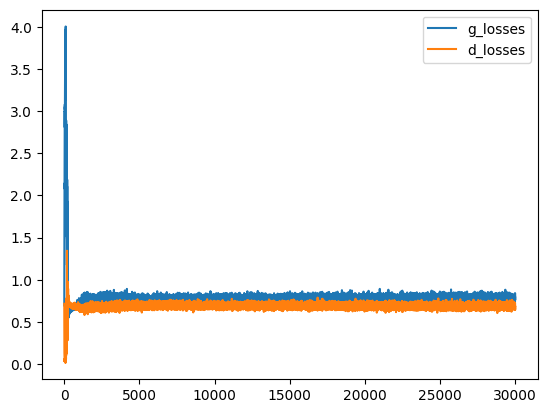

In [ ]:
plt.plot(g_losses,label='g_losses')
plt.plot(d_losses,label='d_losses')
plt.legend()


In [ ]:
!ls gan_images

0.png	   12800.png  16000.png  19000.png  22000.png  25000.png  2800.png   4200.png  7400.png
10000.png  13000.png  1600.png	 19200.png  2200.png   25200.png  28200.png  4400.png  7600.png
1000.png   13200.png  16200.png  19400.png  22200.png  25400.png  28400.png  4600.png  7800.png
10200.png  13400.png  16400.png  19600.png  22400.png  25600.png  28600.png  4800.png  8000.png
10400.png  13600.png  16600.png  19800.png  22600.png  25800.png  28800.png  5000.png  800.png
10600.png  13800.png  16800.png  20000.png  22800.png  26000.png  29000.png  5200.png  8200.png
10800.png  14000.png  17000.png  2000.png   23000.png  2600.png   29200.png  5400.png  8400.png
11000.png  1400.png   17200.png  200.png    23200.png  26200.png  29400.png  5600.png  8600.png
11200.png  14200.png  17400.png  20200.png  23400.png  26400.png  29600.png  5800.png  8800.png
11400.png  14400.png  17600.png  20400.png  23600.png  26600.png  29800.png  6000.png  9000.png
11600.png  14600.png  17800.png  20600.png  

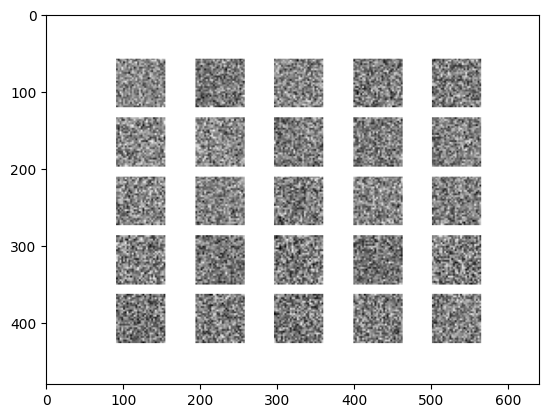

In [ ]:
from skimage.io import imread
a=imread('gan_images/0.png')
plt.imshow(a)

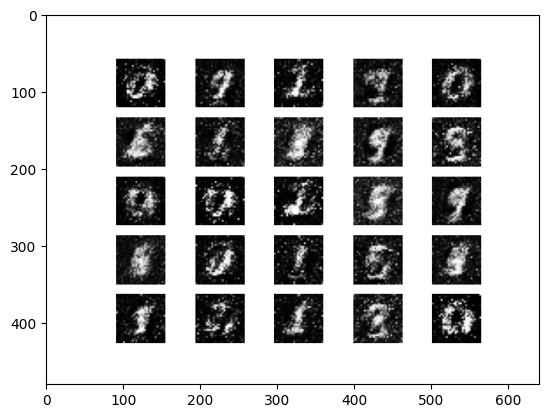

In [ ]:
a=imread('gan_images/1000.png')
plt.imshow(a)

In [ ]:
a=imread('gan_images/5000.png')
plt.imshow(a)

In [ ]:
a=imread('gan_images/10000.png')
plt.imshow(a)

In [ ]:
a=imread('gan_images/20000.png')
plt.imshow(a)

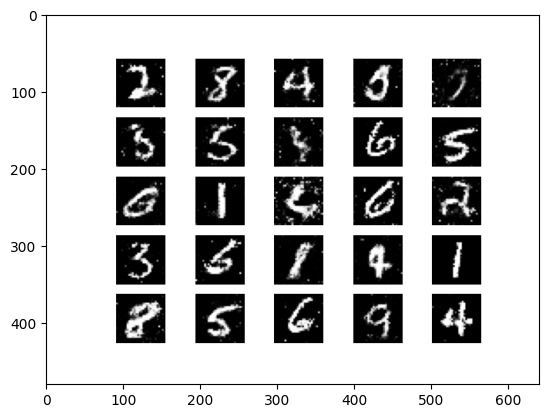

In [ ]:
a=imread('gan_images/29800.png')
plt.imshow(a)